Copyright (c) Microsoft Corporation. All rights reserved.

Licensed under the MIT License.

# Model Development with Custom Weights

This example shows how to retrain a model with custom weights and fine-tune the model with quantization, then deploy the model running on FPGA. Only Windows is supported. We use TensorFlow and Keras to build our model. We are going to use transfer learning, with ResNet50 as a featurizer. We don't use the last layer of ResNet50 in this case and instead add our own classification layer using Keras.

The custom wegiths are trained with ImageNet on ResNet50. We are using a public Top tagging dataset as our training data.

Please set up your environment as described in the [quick start](project-brainwave-quickstart.ipynb).

This work was performed on the Caltech GPU cluster. The specific server is named imperium-sm.hep.caltech.edu. Paths have been set to work in that environment, but must be altered for your purposes.

In [1]:
import os,sys
os.environ['KERAS_BACKEND'] = 'tensorflow'
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
import tensorflow as tf
import numpy as np
from keras import backend as K
import tables
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

Using TensorFlow backend.


[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 8364743155203951284, name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 15578061210
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 5487763574376544320
 physical_device_desc: "device: 0, name: Tesla V100-SXM2-16GB, pci bus id: 0000:00:04.0, compute capability: 7.0"]

## Setup Environment
After you train your model in float32, you'll write the weights to a place on disk. We also need a location to store the models that get downloaded.

In [2]:
# These directories were chosen because they write the data to local disk, which will have the fastest access time
# of our various storage options.
custom_weights_dir = os.path.expanduser("/home/jduarte/machinelearningnotebooks/weights")
saved_model_dir = os.path.expanduser("/home/jduarte/machinelearningnotebooks/models")

## Prepare Data
Load the files we are going to use for training and testing. The public Top dataset consists of image formatted data, but our data has been preprocessed into a raw form.

At the time of writing, the files in question are located at `/data/shared/dwerran/converted`. They are stored in the HDF5 format, and must be accessed via the `tables` module. The two sub-datasets we're interested in are `/img-pt` and `/labels`, corresponding to the images and lables respectively. Each dataset contains 50000 images, and there are about 30 datasets. As before, this storage location was chosen to maximize data bandwidth.

In [3]:
def normalize_and_rgb(images): 
    #normalize image to 0-255 per image.
    image_sum = 1/np.sum(np.sum(images,axis=1),axis=-1)
    given_axis = 0
    # Create an array which would be used to reshape 1D array, b to have 
    # singleton dimensions except for the given axis where we would put -1 
    # signifying to use the entire length of elements along that axis  
    dim_array = np.ones((1,images.ndim),int).ravel()
    dim_array[given_axis] = -1
    # Reshape b with dim_array and perform elementwise multiplication with 
    # broadcasting along the singleton dimensions for the final output
    image_sum_reshaped = image_sum.reshape(dim_array)
    images = images*image_sum_reshaped*255

    # make it rgb by duplicating 3 channels.
    images = np.stack([images, images, images],axis=-1)
    
    return images
def image_with_label(train_file, istart,iend):
    f = tables.open_file(train_file, 'r')
    a = np.array(f.root.img_pt) # Images
    b = np.array(f.root.label) # Labels
    return normalize_and_rgb(a[istart:iend]),b[istart:iend]

In [5]:
import glob
import random

datadir = "/home/jduarte/machinelearningnotebooks/data/"
num_train = 100  # Limit the number of images used in training to shorten epoch time

train_files = glob.glob(os.path.join(datadir, 'train_file_*'))
#train_files = random.choice(train_files)  # Choose one of the training files to use (for now)

# Open the chosen file and extract the dataset
#f = tables.open_file(train_files, 'r')
#a = np.array(f.root.img_pt) # Images
#b = np.array(f.root.label) # Labels
# Randomly shuffle label and images, keep the indexing
#c = np.c_[a.reshape(len(a), -1), b.reshape(len(b), -1)]
#np.random.shuffle(c)
#train_images = c[:, :a.size//len(a)].reshape(a.shape)
#train_labels = c[:, a.size//len(a):].reshape(b.shape)

# Limit the data set to make the notebook execute quickly.
#train_images = train_images[:num_train]
#train_labels = train_labels[:num_train]

#train_images = normalize_and_rgb(train_images)

In [6]:
num_test = 100

test_files = glob.glob(os.path.join(datadir, 'test/test_file_*'))
test_files = random.choice(test_files)  # Choose one of the training files to use (for now)

# Open the chosen file and extract the dataset
f = tables.open_file(test_files, 'r')
a = np.array(f.root.img_pt) # Images
b = np.array(f.root.label) # Labels
#print(b[:50])
# Randomly shuffle label and images, keep the indexing
c = np.c_[a.reshape(len(a), -1), b.reshape(len(b), -1)]
np.random.shuffle(c)
test_images = c[:, :a.size//len(a)].reshape(a.shape)
test_labels = c[:, a.size//len(a):].reshape(b.shape)

# Limit the data set to make the notebook execute quickly.
test_images = test_images[:num_test]
test_labels = test_labels[:num_test]

test_images = normalize_and_rgb(test_images)

## Construct Model
We use ResNet50 for the featuirzer and build our own classifier using Keras layers. We train the featurizer and the classifier as one model. The weights trained on ImageNet are used as the starting point for the retraining of our featurizer. The weights are loaded from tensorflow checkpoint files.

Before passing image dataset to the ResNet50 featurizer, we need to preprocess the input file to get it into the form expected by ResNet50. ResNet50 expects float tensors representing the images in BGR, channel last order. Given that our images are greyscale, this isn't relevant to us, as we will simply be copying the data in place.

In [7]:
#import sys
#!{sys.executable} -m pip install --upgrade azureml-sdk[notebooks,automl] azureml-dataprep
#!{sys.executable} -m pip install --upgrade azureml-sdk[contrib]

import azureml.contrib.brainwave.models.utils as utils

def preprocess_images():
    # Create a placeholder for our incoming images
    in_images = tf.placeholder(tf.float32)
    in_height = 64
    in_width = 64
    in_images.set_shape([None, in_height, in_width, 3])
    
    # Resize those images to fit our featurizer
    out_width = 224
    out_height = 224
    image_tensors = tf.image.resize_images(in_images, [out_height,out_width])
    image_tensors = tf.to_float(image_tensors)
    
    return in_images, image_tensors

We use Keras layer APIs to construct the classifier. Because we're using the tensorflow backend, we can train this classifier in one session with our Resnet50 model.

In [8]:
def construct_classifier(in_tensor):
    from keras.layers import Dropout, Dense, Flatten
    K.set_session(tf.get_default_session())
    
    FC_SIZE = 1024
    NUM_CLASSES = 2

    x = Dropout(0.2, input_shape=(1, 1, 2048,))(in_tensor)
    x = Dense(FC_SIZE, activation='relu', input_dim=(1, 1, 2048,))(x)
    x = Flatten()(x)
    preds = Dense(NUM_CLASSES, activation='softmax', input_dim=FC_SIZE, name='classifier_output')(x)
    return preds

Now every component of the model is defined, we can construct the model. Constructing the model with the project brainwave models is two steps - first we import the graph definition, then we restore the weights of the model into a tensorflow session. Because the quantized graph defintion and the float32 graph defintion share the same node names in the graph definitions, we can initally train the weights in float32, and then reload them with the quantized operations (which take longer) to fine-tune the model.

In [10]:
def construct_model(quantized, starting_weights_directory = None):
    from azureml.contrib.brainwave.models import Resnet50, QuantizedResnet50
    
    # Convert images to 3D tensors [width,height,channel]
    in_images, image_tensors = preprocess_images()

    # Construct featurizer using quantized or unquantized ResNet50 model
    if not quantized:
        featurizer = Resnet50(saved_model_dir)
    else:
        featurizer = QuantizedResnet50(saved_model_dir, custom_weights_directory = starting_weights_directory)

    features = featurizer.import_graph_def(input_tensor=image_tensors)
    # Construct classifier
    preds = construct_classifier(features)

    # Initialize weights
    sess = tf.get_default_session()
    tf.global_variables_initializer().run()

    featurizer.restore_weights(sess)

    return in_images, image_tensors, features, preds, featurizer

## Train Model
First we train the model with custom weights but without quantization. Training is done with native float precision (32-bit floats). We load the traing data set and batch the training with 10 epochs. When the performance reaches desired level or starts decredation, we stop the training iteration and save the weights as tensorflow checkpoint files. 

In [11]:
n_train_file = 25
n_events = 1200000
#n_train_file = 1
#n_events = 50000
chunk_size = 64
def train_model(preds, in_images, train_files, is_retrain = False, train_epoch = 10, saver=None, checkpoint_path = None):
    """ training model """
    from keras.objectives import binary_crossentropy
    from keras.metrics import categorical_accuracy
    from tqdm import tqdm
    
    learning_rate = 0.001 if is_retrain else 0.01
        
    # Specify the loss function
    in_labels = tf.placeholder(tf.float32, shape=(None, 2))   
    cross_entropy = tf.reduce_mean(binary_crossentropy(in_labels, preds))
    optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(cross_entropy)
    
    accuracy = tf.reduce_mean(categorical_accuracy(in_labels, preds))
    auc = tf.metrics.auc(tf.cast(in_labels, tf.bool), preds)
    
    def chunks(istart,chunksize):
        """Yield successive n-sized chunks from a and b."""
        for train_file in train_files[:n_train_file]:
            f = tables.open_file(train_file, 'r')
            a = np.array(f.root.img_pt) # Images
            b = np.array(f.root.label) # Labels
            for istart in range(0,a.shape[0],chunksize):
                yield normalize_and_rgb(a[istart:istart+chunksize]),b[istart:istart+chunksize]
        #for i in range(0, num_train, n):
         #   yield a[i:i + n], b[i:i + n]

    chunk_num = len(train_files[:n_train_file])*n_events / chunk_size

    sess = tf.get_default_session()
    sess.run(tf.group(tf.global_variables_initializer(), tf.local_variables_initializer()))
    
    loss_over_epoch = []
    accuracy_over_epoch = []
    auc_over_epoch = []
    
    for epoch in range(train_epoch):
        avg_loss = 0
        avg_accuracy = 0
        avg_auc = 0
        for img_chunk, label_chunk in tqdm(chunks(train_files, chunk_size)):
            _, loss = sess.run([optimizer, cross_entropy],
                                feed_dict={in_images: img_chunk,
                                           in_labels: label_chunk,
                                           K.learning_phase(): 1})
            avg_loss += loss / chunk_num
            accuracy_result, auc_result = sess.run([accuracy, auc],
                                     feed_dict={in_images: test_images,
                                                in_labels: test_labels,
                                                K.learning_phase(): 0})
            avg_accuracy += accuracy_result / chunk_num
            avg_auc += auc_result[1] / chunk_num
        print("Epoch:", (epoch + 1), "loss = ", "{:.3f}".format(avg_loss))
        print("Accuracy:", "{:.3f}".format(avg_accuracy), ", Area under ROC curve:", "{:.3f}".format(avg_auc))
            
        loss_over_epoch.append(avg_loss)
        accuracy_over_epoch.append(avg_accuracy)
        auc_over_epoch.append(avg_auc)
        
        if saver is not None and checkpoint_path is not None:
            saver.save(sess, checkpoint_path, write_meta_graph=False, global_step = epoch)
            
        # Reach desired performance
        if (avg_loss < 0.001):
            break
            
    return loss_over_epoch, accuracy_over_epoch, auc_over_epoch
            

In [12]:
def test_model(preds, in_images, test_images, test_labels):
    """Test the model"""
    from keras.metrics import categorical_accuracy

    in_labels = tf.placeholder(tf.float32, shape=(None, 2))
    accuracy = tf.reduce_mean(categorical_accuracy(in_labels, preds))
    auc = tf.metrics.auc(tf.cast(in_labels, tf.bool), preds)
    
    sess.run(tf.group(tf.global_variables_initializer(), tf.local_variables_initializer()))
    accuracy, auc = sess.run([accuracy, auc],
                    feed_dict={in_images: test_images,
                               in_labels: test_labels,
                               K.learning_phase(): 0})
    
    return accuracy, auc

This training currently leverages a hack to work around some apparent limits in the BW API. I have attempted to specify a custom weights directory when calling the `Resnet50` function in `construct_model()` above in the same way it is specified for `Quantized_Resnet50`. However, this throws an error, and since there is no API documentation yet, the way I'm working around it is rewriting our trained weights to the saved model directory. I will be reaching out to the team on this topic to see if they have a better suggestion.

In [ ]:
# Launch the training
version = '1.1.3'
tf.reset_default_graph()
sess = tf.Session(graph=tf.get_default_graph())

num_epoch_train = 10

with sess.as_default():
    in_images, image_tensors, features, preds, featurizer = construct_model(quantized=False)
    saver = tf.train.Saver()
    loss_over_epoch, accuracy_over_epoch, auc_over_epoch = \
        train_model(preds, in_images, train_files, is_retrain=False, train_epoch=num_epoch_train, saver=saver, checkpoint_path=saved_model_dir + "/rn50/"+version+"/resnet50_bw")    
    accuracy, auc = test_model(preds, in_images, test_images, test_labels)  
    # print("Accuracy:", accuracy, ", Area under ROC curve:", auc)
    featurizer.save_weights(saved_model_dir + "/rn50/"+version+"/resnet50_bw", tf.get_default_session())

INFO:tensorflow:Restoring parameters from /home/jduarte/machinelearningnotebooks/models/rn50/1.1.3/resnet50_bw


1it [00:12, 12.94s/it]

## Test Model
After training, we evaluate the trained model's accuracy on test dataset with quantization. So that we know the model's performance if it is deployed on the FPGA.

In [31]:
tf.reset_default_graph()
sess = tf.Session(graph=tf.get_default_graph())

merged = tf.summary.merge_all()


with sess.as_default():
    print("Testing trained model with quantization")
    in_images, image_tensors, features, preds, quantized_featurizer = construct_model(quantized=True, starting_weights_directory=saved_model_dir + "/rn50/"+version+"/")
    accuracy, auc = test_model(preds, in_images, test_images, test_labels)      
    print("Accuracy:", accuracy, ", Area under ROC curve:", auc)

Testing trained model with quantization
INFO:tensorflow:Restoring parameters from /data/shared/mliu/custom-weights-retrain/models/rn50/1.1.3/resnet50_bw
Accuracy: 0.45 , Area under ROC curve: (0.0, 0.5618)


## Fine-Tune Model
Sometimes, the model's accuracy can drop significantly after quantization. In those cases, we need to retrain the model enabled with quantization to get better model accuracy.

In [32]:
# while (accuracy < 0.93):  # This replaces "if (accuracy...)" in the original notebook

num_epoch_finetune = 10

if (accuracy < 0.93):
    with sess.as_default():
        print("Fine-tuning model with quantization")
        loss_over_epoch_ft, accuracy_over_epoch_ft, auc_over_epoch_ft = \
            train_model(preds, in_images, train_images, train_labels, is_retrain=True, train_epoch=num_epoch_finetune)
        accuracy = test_model(preds, in_images, test_images, test_labels)        
        # print("Accuracy:", accuracy)
        featurizer.save_weights(saved_model_dir + "/rn50/"+version+"/resnet50_bw", tf.get_default_session())

loss_over_epoch = loss_over_epoch + loss_over_epoch_ft
accuracy_over_epoch = accuracy_over_epoch + accuracy_over_epoch_ft
auc_over_epoch = auc_over_epoch + auc_over_epoch_ft

Fine-tuning model with quantization




0it [00:00, ?it/s]

1it [00:17, 17.89s/it]

2it [00:19, 13.03s/it]

3it [00:21,  9.63s/it]

4it [00:22,  7.25s/it]

5it [00:24,  5.59s/it]

6it [00:26,  4.42s/it]

7it [00:27,  3.53s/it]



0it [00:00, ?it/s]

Epoch: 1 loss =  0.847
Accuracy: 0.608 , Area under ROC curve: 0.636




1it [00:01,  1.71s/it]

2it [00:03,  1.71s/it]

3it [00:05,  1.71s/it]

4it [00:06,  1.70s/it]

5it [00:08,  1.70s/it]

6it [00:10,  1.70s/it]

7it [00:11,  1.63s/it]



0it [00:00, ?it/s]

Epoch: 2 loss =  0.911
Accuracy: 0.720 , Area under ROC curve: 0.697




1it [00:01,  1.70s/it]

2it [00:03,  1.70s/it]

3it [00:05,  1.70s/it]

4it [00:06,  1.70s/it]

5it [00:08,  1.70s/it]

6it [00:10,  1.70s/it]

7it [00:11,  1.63s/it]



0it [00:00, ?it/s]

Epoch: 3 loss =  0.850
Accuracy: 0.736 , Area under ROC curve: 0.730




1it [00:01,  1.70s/it]

2it [00:03,  1.70s/it]

3it [00:05,  1.70s/it]

4it [00:06,  1.70s/it]

5it [00:08,  1.70s/it]

6it [00:10,  1.70s/it]

7it [00:11,  1.63s/it]



0it [00:00, ?it/s]

Epoch: 4 loss =  0.814
Accuracy: 0.734 , Area under ROC curve: 0.750




1it [00:01,  1.70s/it]

2it [00:03,  1.70s/it]

3it [00:05,  1.70s/it]

4it [00:06,  1.70s/it]

5it [00:08,  1.70s/it]

6it [00:10,  1.70s/it]

7it [00:11,  1.63s/it]



0it [00:00, ?it/s]

Epoch: 5 loss =  0.768
Accuracy: 0.779 , Area under ROC curve: 0.766




1it [00:01,  1.70s/it]

2it [00:03,  1.70s/it]

3it [00:05,  1.70s/it]

4it [00:06,  1.70s/it]

5it [00:08,  1.70s/it]

6it [00:10,  1.70s/it]

7it [00:11,  1.63s/it]



0it [00:00, ?it/s]

Epoch: 6 loss =  0.745
Accuracy: 0.778 , Area under ROC curve: 0.781




1it [00:01,  1.70s/it]

2it [00:03,  1.70s/it]

3it [00:05,  1.70s/it]

4it [00:06,  1.70s/it]

5it [00:08,  1.70s/it]

6it [00:10,  1.70s/it]

7it [00:11,  1.63s/it]



0it [00:00, ?it/s]

Epoch: 7 loss =  0.734
Accuracy: 0.789 , Area under ROC curve: 0.793




1it [00:01,  1.70s/it]

2it [00:03,  1.70s/it]

3it [00:05,  1.70s/it]

4it [00:06,  1.70s/it]

5it [00:08,  1.70s/it]

6it [00:10,  1.70s/it]

7it [00:11,  1.63s/it]



0it [00:00, ?it/s]

Epoch: 8 loss =  0.716
Accuracy: 0.794 , Area under ROC curve: 0.801




1it [00:01,  1.70s/it]

2it [00:03,  1.70s/it]

3it [00:05,  1.70s/it]

4it [00:06,  1.70s/it]

5it [00:08,  1.70s/it]

6it [00:10,  1.70s/it]

7it [00:11,  1.63s/it]



0it [00:00, ?it/s]

Epoch: 9 loss =  0.707
Accuracy: 0.782 , Area under ROC curve: 0.808




1it [00:01,  1.70s/it]

2it [00:03,  1.70s/it]

3it [00:05,  1.70s/it]

4it [00:06,  1.70s/it]

5it [00:08,  1.70s/it]

6it [00:10,  1.70s/it]

7it [00:11,  1.63s/it]



Epoch: 10 loss =  0.738
Accuracy: 0.795 , Area under ROC curve: 0.813


Now let's do some plotting. We're going to take the data from the first training run and append it to the data from the second. You'll see a drop in the accuracy and an increase in loss at that time, but it should eventually return to nominal values.

20
20
[3.35220001 2.74592185 2.03604607 1.51339635 1.53612544 1.37433217
 1.40170875 1.30450426 1.28792554]


([<matplotlib.axis.XTick at 0x7fab8e9d7cc0>,
 <a list of 20 Text xticklabel objects>)

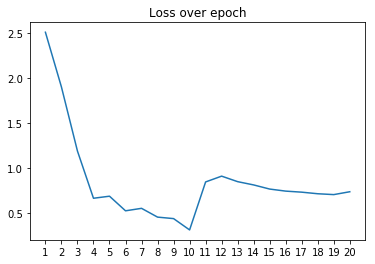

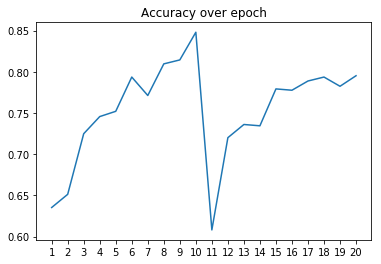

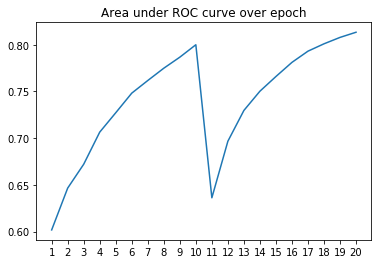

In [42]:
import matplotlib.pyplot as plt
# Create our x-axis, which should be integers only since we're counting epochs
x = range(1, len(loss_over_epoch)+1)
print(len(x))
print(len(loss_over_epoch))
print(loss_over_epoch[0:9] + loss_over_epoch[10])

plt.figure(0)
plt.plot(x, loss_over_epoch)
plt.title("Loss over epoch")
plt.xticks(x)

plt.figure(1)
plt.plot(x, accuracy_over_epoch)
plt.title("Accuracy over epoch")
plt.xticks(x)

plt.figure(2)
plt.plot(x, auc_over_epoch)
plt.title("Area under ROC curve over epoch")
plt.xticks(x)

## Service Definition
Like in the QuickStart notebook our service definition pipeline consists of three stages. 

In [14]:
from azureml.contrib.brainwave.pipeline import ModelDefinition, TensorflowStage, BrainWaveStage

model_def_path = os.path.join(saved_model_dir, 'model_def.zip')

model_def = ModelDefinition()
model_def.pipeline.append(TensorflowStage(sess, in_images, image_tensors))
model_def.pipeline.append(BrainWaveStage(sess, quantized_featurizer))
model_def.pipeline.append(TensorflowStage(sess, features, preds))
model_def.save(model_def_path)
print(model_def_path)

INFO:tensorflow:Froze 0 variables.
Converted 0 variables to const ops.
INFO:tensorflow:Restoring parameters from /data/shared/dwerran/custom-weights-retrain/models/rn50/1.1.3/resnet50_bw
INFO:tensorflow:Froze 4 variables.
Converted 4 variables to const ops.
/data/shared/dwerran/custom-weights-retrain/models/model_def.zip


## Deploy
Go to our [GitHub repo](https://aka.ms/aml-real-time-ai) "docs" folder to learn how to create a Model Management Account and find the required information below.

In [15]:
from azureml.core import Workspace

ws = Workspace.from_config()

Found the config file in: /nfshome/dwerran/MachineLearningNotebooks/aml_config/config.json


The first time the code below runs it will create a new service running your model. If you want to change the model you can make changes above in this notebook and save a new service definition. Then this code will update the running service in place to run the new model.

In [16]:
from azureml.core.model import Model
from azureml.core.image import Image
from azureml.core.webservice import Webservice
from azureml.contrib.brainwave import BrainwaveWebservice, BrainwaveImage
from azureml.exceptions import WebserviceException

model_name = "top-transfer-resnet50-model"
image_name = "top-transfer-resnet50-image"
service_name = "modelbuild-service"

registered_model = Model.register(ws, model_def_path, model_name)

image_config = BrainwaveImage.image_configuration()
deployment_config = BrainwaveWebservice.deploy_configuration()
    
try:
    service = Webservice(ws, service_name)
    service.delete()
    service = Webservice.deploy_from_model(ws, service_name, [registered_model], image_config, deployment_config)
    service.wait_for_deployment(True)
except WebserviceException:
    service = Webservice.deploy_from_model(ws, service_name, [registered_model], image_config, deployment_config)
    service.wait_for_deployment(True)

Registering model top-transfer-resnet50-model
Creating image
Image creation operation finished for image modelbuild-service:8, operation "Succeeded"
Creating service


WebserviceException: Received bad response from Model Management Service:
Response Code: 504
Headers: {'Date': 'Fri, 14 Dec 2018 20:28:55 GMT', 'Content-Type': 'text/html', 'Content-Length': '176', 'Connection': 'keep-alive', 'Strict-Transport-Security': 'max-age=15724800; includeSubDomains; preload'}
Content: b'<html>\r\n<head><title>504 Gateway Time-out</title></head>\r\n<body bgcolor="white">\r\n<center><h1>504 Gateway Time-out</h1></center>\r\n<hr><center>nginx</center>\r\n</body>\r\n</html>\r\n'

The service is now running in Azure and ready to serve requests. We can check the address and port.

In [ ]:
print(service.ip_address + ':' + str(service.port))

## Client
There is a simple test client at amlrealtimeai.PredictionClient which can be used for testing. We'll use this client to score an image with our new service.

In [ ]:
from azureml.contrib.brainwave.client import PredictionClient
client = PredictionClient(service.ip_address, service.port)

You can adapt the client [code](../../pythonlib/amlrealtimeai/client.py) to meet your needs. There is also an example C# [client](../../sample-clients/csharp).

The service provides an API that is compatible with TensorFlow Serving. There are instructions to download a sample client [here](https://www.tensorflow.org/serving/setup).

## Request
Let's see how our service does on a few images. It may get a few wrong.

In [ ]:
# Specify an image to classify
for i in range(10):
    image_file = test_images[i]
    label = test_labels[i]
    results = client.score_image(image_file)
    result = 'CORRECT ' if (results[0] > results[1]) == label[0] else 'WRONG '
    print(result + str(results))

## Cleanup
Run the cell below to delete your service.

In [ ]:
service.delete()

## Appendix

License for plot_confusion_matrix:

New BSD License

Copyright (c) 2007-2018 The scikit-learn developers.
All rights reserved.


Redistribution and use in source and binary forms, with or without
modification, are permitted provided that the following conditions are met:

  a. Redistributions of source code must retain the above copyright notice,
     this list of conditions and the following disclaimer.
  b. Redistributions in binary form must reproduce the above copyright
     notice, this list of conditions and the following disclaimer in the
     documentation and/or other materials provided with the distribution.
  c. Neither the name of the Scikit-learn Developers  nor the names of
     its contributors may be used to endorse or promote products
     derived from this software without specific prior written
     permission. 


THIS SOFTWARE IS PROVIDED BY THE COPYRIGHT HOLDERS AND CONTRIBUTORS "AS IS"
AND ANY EXPRESS OR IMPLIED WARRANTIES, INCLUDING, BUT NOT LIMITED TO, THE
IMPLIED WARRANTIES OF MERCHANTABILITY AND FITNESS FOR A PARTICULAR PURPOSE
ARE DISCLAIMED. IN NO EVENT SHALL THE REGENTS OR CONTRIBUTORS BE LIABLE FOR
ANY DIRECT, INDIRECT, INCIDENTAL, SPECIAL, EXEMPLARY, OR CONSEQUENTIAL
DAMAGES (INCLUDING, BUT NOT LIMITED TO, PROCUREMENT OF SUBSTITUTE GOODS OR
SERVICES; LOSS OF USE, DATA, OR PROFITS; OR BUSINESS INTERRUPTION) HOWEVER
CAUSED AND ON ANY THEORY OF LIABILITY, WHETHER IN CONTRACT, STRICT
LIABILITY, OR TORT (INCLUDING NEGLIGENCE OR OTHERWISE) ARISING IN ANY WAY
OUT OF THE USE OF THIS SOFTWARE, EVEN IF ADVISED OF THE POSSIBILITY OF SUCH
DAMAGE.
